In [ ]:
from stats_can import StatsCan
sc = StatsCan()
# Annual stock of active vehicle registrations
fleet = sc.table_to_df("23-10-0308-01")     # ≈ 80 k rows


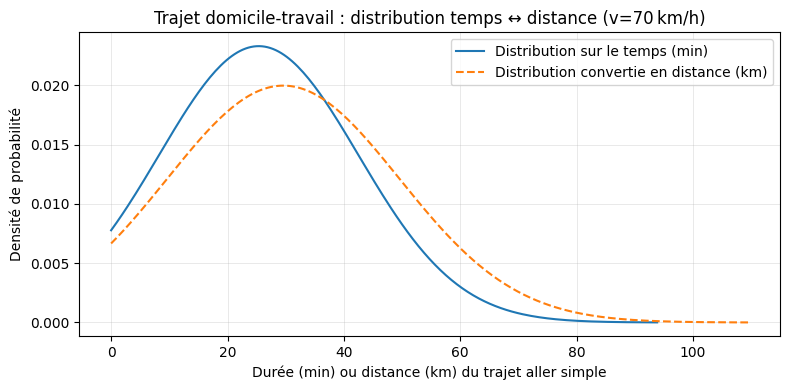

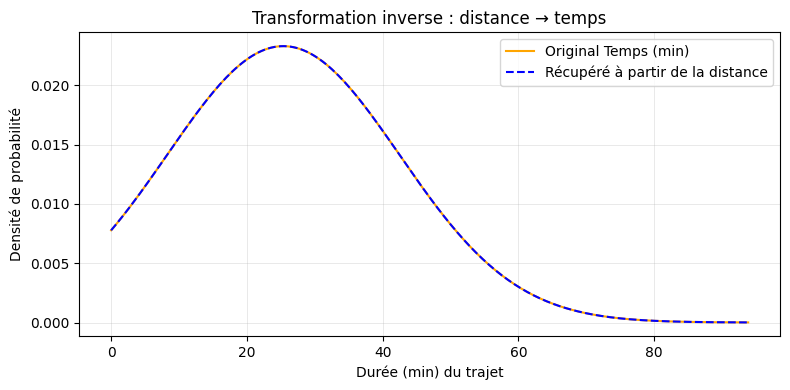

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# --- Input data -------------------------------------------------------------
COUNTS = {"<15": 4_178_570, "15-29": 4_546_195,
          "30-44": 2_487_010, "45-59": 910_610, "≥60": 926_120}
MIDPTS = {"<15": 7.5, "15-29": 22, "30-44": 37, "45-59": 52, "≥60": 65}

def to_percent(counts):
    tot = float(sum(counts.values()))
    return {k: v / tot * 100.0 for k, v in counts.items()}

def gaussian_from_percent(percent, midpoints, n_points=200):
    keys = list(percent)
    p = np.array([percent[k] for k in keys]) / 100.0
    m = np.array([midpoints[k] for k in keys])
    mu = (p * m).sum()
    sigma = np.sqrt((p * (m - mu) ** 2).sum())
    x = np.linspace(max(0, mu - 4 * sigma), mu + 4 * sigma, n_points)
    y = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-0.5*((x - mu) / sigma)**2)
    return x, y

def time_to_distance(x_time, y_time, speed_kmh=70.0):
    k = speed_kmh / 60.0
    x_dist = x_time * k
    y_dist = y_time / k   # change‑of‑variable scaling
    return x_dist, y_dist

percent = to_percent(COUNTS)
x_time, y_time = gaussian_from_percent(percent, MIDPTS)
x_dist, y_dist = time_to_distance(x_time, y_time, speed_kmh=70)

plt.figure(figsize=(8, 4))
plt.plot(x_time, y_time, label="Distribution sur le temps (min)")
plt.plot(x_dist, y_dist, linestyle="--",
         label="Distribution convertie en distance (km)")
plt.xlabel("Durée (min) ou distance (km) du trajet aller simple")
plt.ylabel("Densité de probabilité")
plt.title("Trajet domicile‑travail : distribution temps ↔ distance (v=70 km/h)")
plt.legend()
plt.grid(True, linewidth=0.5, alpha=0.4)
plt.tight_layout()
plt.show()


from scipy.interpolate import interp1d

# Suppose we only have (x_dist, y_dist)
k = 70 / 60.0

# 1. Interpolation de la densité distance pour accès facile
interp_dist = interp1d(x_dist, y_dist, bounds_error=False, fill_value=0)

# 2. On crée un nouvel axe pour le temps (min)
x_time_inv = np.linspace(0, max(x_time), 200)
# 3. On calcule la densité sur le temps par l'inverse du changement de variable
y_time_inv = interp_dist(k * x_time_inv) * k

# 4. Tracé pour comparaison avec l’original
plt.figure(figsize=(8, 4))
plt.plot(x_time, y_time, label="Original Temps (min)", color="orange")
plt.plot(x_time_inv, y_time_inv, '--', label="Récupéré à partir de la distance", color="blue")
plt.xlabel("Durée (min) du trajet")
plt.ylabel("Densité de probabilité")
plt.title("Transformation inverse : distance → temps")
plt.legend()
plt.grid(True, linewidth=0.5, alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
# pip install stats-can pandas
from stats_can import StatsCan
import pandas as pd
def get_fleet()-> pd.DataFrame:
    """
    Get the annual stock of active vehicle registrations in Canada."""
    sc = StatsCan()
    tbl = sc.table_to_df("23-10-0308-01")             # ≈ 80 k rows, cached

    # --- keep latest reference year and the total stock of vehicles ------------
    latest_year = tbl["REF_DATE"].max()               # 2023, as of May 2025
    fleet = tbl[(tbl["REF_DATE"] == latest_year)]

    # --- pivot into one row per province ---------------------------------------
    prov_fleet = (fleet[["GEO", "VALUE", "Vehicle Type", "Fuel Type"]]
                  .rename(columns={"GEO": "Province", "VALUE": "Vehicles", "Vehicle Type": "Type", "Fuel Type": "Fuel"})
                  .set_index("Province")
                  .sort_index())
    return prov_fleet


In [ ]:
from stats_can import StatsCan
import pandas as pd

# 1. pull the fleet table
sc    = StatsCan()
tbl   = sc.table_to_df("23-10-0308-01")
year  = tbl["REF_DATE"].max()

# 2. keep only the light-duty fleet, all fuel types
base = (
    tbl[(tbl["REF_DATE"] == year) &
        (tbl["Vehicle Type"] == "Light-duty vehicle")]
    [["GEO", "Vehicle Type", "Fuel Type", "VALUE"]]
    .rename(columns={
        "GEO":   "Region",
        "VALUE": "Count",
        "Fuel Type": "Fuel",
    })
)

stock = base.pivot_table(
    index=["Region","Vehicle Type", "Fuel Type"],
    columns="Fuel",
    values="Count",
    fill_value=0
).reset_index()



In [ ]:
def simulate_electrification(df, frac_e=1.0, frac_h=0.0, keep_non=0.0):
    """
    df : the pivoted stock DataFrame.
    frac_e : fraction of non-EV replaced by EV
    frac_h : fraction of non-EV replaced by HEV
    keep_non: fraction of non-EV left unchanged
    (must satisfy frac_e + frac_h + keep_non == 1)
    """
    out = df.copy()
    non_ev = out[out["Fuel"] == "All fuel types"] - out[out["Fuel"] == "Battery-electric"] - out[out["Fuel"]=="Hybrid-electric"]
    
    # how many get converted
    to_ev = frac_e * non_ev
    to_hev = frac_h * non_ev
    keep   = keep_non * non_ev

    out[out["Fuel"] =="Battery-electric"] += to_ev
    out[out["Fuel"] == "Hybrid-electric"] += to_hev
    out[out["Fuel"] == "Gasoline"]        = keep   # or whatever your “other” fuel column is

    return out


In [ ]:
stock = get_fleet()  # run this to get the fleet data

# 100% electric replacement:
sim100e = simulate_electrification(stock, frac_e=1.0, frac_h=0.0, keep_non=0.0)

# 50/50 electric / hybrid:
sim50_50 = simulate_electrification(stock, frac_e=0.5, frac_h=0.5, keep_non=0.0)

# 100% hybrid:
sim100h = simulate_electrification(stock, frac_e=0.0, frac_h=1.0, keep_non=0.0)


In [ ]:
# ────────────────────────────────────────────────────────────
#  PROVINCE-LEVEL DAILY DRIVING DISTANCES  (NRCan Table 21)
#  Works with pandas ≥ 1.3  |  Only std-lib + pandas required
# ────────────────────────────────────────────────────────────
import pandas as pd, numpy as np, re
import matplotlib.pyplot as plt


# ---------- CONFIGURATION -----------------------------------
YEAR          = 2022                 # latest panel on page=2
PROVINCES     = ["on", "qc", "ab", "bct", "ns", "nl", "pe", "mb", "sk", "nb"]  # NRCan 'juris' codes
WEEKDAY_SHARE = 0.80                 # CVS-2009: 80 % of km Mon-Fri
WEEKEND_SHARE = 0.20
WKDAYS_2022   = 261                  # Mon-Fri days in 2022
WKENDS_2022   = 104                  # Sat+Sun days in 2022
SIGMA_LN      = 0.9                 # generic σ from CVS micro-data
URL_TPL = ("https://oee.nrcan.gc.ca/corporate/statistics/neud/dpa/"
           "showTable.cfm?juris={prov}&page=2&rn=21&sector=tran&type=CP&year={yr}")

# ---------- HELPERS -----------------------------------------
def fetch_table(prov: str, yr: int = YEAR) -> pd.DataFrame:
    """Return the raw one-column DataFrame for NRCan Table 21 page 2."""
    return pd.read_html(URL_TPL.format(prov=prov, yr=yr), header=None)[0]

def annual_km(df: pd.DataFrame, yr: int = YEAR) -> int:
    """Extract 'Average Distance Travelled per Year (km)' as an int."""
    col = str(yr)
    raw_val =df[col].iloc[4].iloc[0]
    # strip commas / blanks and cast
    return int(re.sub(r"[^\d]", "", str(raw_val)))

def daily_split(km_year: int) -> tuple[float, float]:
    """Return (weekday_km, weekend_km) per car per day."""
    wkday = km_year * WEEKDAY_SHARE / WKDAYS_2022
    wkend = km_year * WEEKEND_SHARE / WKENDS_2022
    return wkday, wkend

def mu_from_mean(mean: float, sigma: float = SIGMA_LN) -> float:
    """Convert arithmetic mean to μ for a log-normal."""
    return np.log(mean) - 0.5 * sigma**2

# ---------- MAIN LOOP ---------------------------------------
results = {}
for prov in PROVINCES:
    df      = fetch_table(prov)
    km_yr   = annual_km(df)
    wkday_km, wkend_km = daily_split(km_yr)

    results[prov.upper()] = {
        "year":         YEAR,
        "annual_km":    km_yr,
        "wkday_km":     wkday_km,
        "wkend_km":     wkend_km,
        "μ_wkday":      mu_from_mean(wkday_km),
        "μ_wkend":      mu_from_mean(wkend_km),
        "σ":            SIGMA_LN,
    }

# ---------- QUICK DISPLAY -----------------------------------
for p, v in results.items():
    print(f"{p} {v['year']}: "
          f"{v['annual_km']:,} km / yr  →  "
          f"{v['wkday_km']:.1f} km weekday, {v['wkend_km']:.1f} km weekend; "
          f"log-normal μ_wkday={v['μ_wkday']:.2f}, μ_wkend={v['μ_wkend']:.2f}, σ={v['σ']}")
    

provinces = list(results.keys())
wkday_logs = [(results[p]["wkday_km"]) for p in provinces]
wkend_logs = [(results[p]["wkend_km"]) for p in provinces]

x = np.arange(len(provinces))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, wkday_logs, width, label="Weekday ln(km)")
plt.bar(x + width/2, wkend_logs, width, label="Weekend ln(km)")

plt.ylabel("Natural log of km per car per day")
plt.title("Log‑scale daily driving distance\n(Weekday vs Weekend, 2022)")
plt.xticks(x, provinces)
plt.legend()
plt.tight_layout()

plt.show()


In [1]:
import carUsage

hoyeah = carUsage.CarUsage()
hoyeah.fetchData()

Done
Car usage data fetched and processed.
Average distance traveled per year (km):
  ON: 14251
  QC: 12435
  AB: 9961
  BCT: 10767
  NS: 16293
  NL: 15836
  PE: 13093
  MB: 16236
  SK: 14619
  NB: 13474
  CA: 13696.5
Average distance traveled per weekday (km):
  ON: 43.681226053639854
  QC: 38.11494252873563
  AB: 30.531800766283524
  BCT: 33.00229885057471
  NS: 49.94022988505748
  NL: 48.539463601532574
  PE: 40.13180076628353
  MB: 49.765517241379314
  SK: 44.809195402298855
  NB: 41.29961685823755
  CA: 41.9816091954023
Average distance traveled per weekend (km):
  ON: 27.405769230769234
  QC: 23.91346153846154
  AB: 19.15576923076923
  BCT: 20.70576923076923
  NS: 31.332692307692312
  NL: 30.453846153846158
  PE: 25.17884615384616
  MB: 31.223076923076924
  SK: 28.11346153846154
  NB: 25.911538461538463
  CA: 26.339423076923076
Done


In [ ]:
import requests, io

def load_statscan(region: str = "Ontario") -> pd.DataFrame:
    BASE = "https://www150.statcan.gc.ca/pub/71-607-x/2022018/"
    REG  = dict(Ontario="tf-ft-eng",  # one big CSV, filter later
                Alberta ="tf-ft-eng",
                Calgary ="tf-ft-eng",
                Toronto ="tf-ft-eng",
                Montreal="tf-ft-eng")[region]
    url  = f"{BASE}{REG}.csv"

    raw  = requests.get(url, timeout=40).content
    df   = pd.read_csv(io.BytesIO(raw), engine="python")   #  ← fixed

    # --- keep only the rows you want ---
    if region == "Ontario":
        df = df[df["province"] == "Ontario"]
    elif region == "Alberta":
        df = df[df["province"] == "Alberta"]
    # (cities are already separate columns — filter the same way)

    df["timestamp"] = pd.to_datetime(df["datetime_utc"])
    df = (df.rename(columns={"vehicle_count": "volume"})
            [["camera_id", "timestamp", "volume"]])
    return df

yeeeeee = load_statscan("Ontario")  # run this to get the Ontario data



In [ ]:
import carRecharge
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import lognorm

# Create dummy data to satisfy the constructor
days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
dummy_data = pd.DataFrame({
    "Day": np.random.choice(days, size=500)
})

usage = carRecharge.CarRecharge(dummy_data)

# 1) Test basic percentage assignment
usage.set_car_charging_perc(day="Monday",
    charging=[(1, 0.5), (12, 0.25), (18, 0.25)])
# 2) Test Gaussian-based profile for Tuesday
usage.set_car_charging_prop(day="Tuesday",
    peaks=[(8,0.25),(12,0.25),(18,0.5)],
    base=0.01, sigma=1.5)

# --- Part A: plot raw profiles ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, day in zip(axes, ["Monday","Tuesday"]):
    profile = usage.charging_profile[day]
    ax.plot(range(24), profile, marker='o')
    ax.set_title(f"{day} Charging Profile")
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Charging %")
    ax.set_xticks(range(0,24,3))
plt.tight_layout()
plt.show()

# --- Part B: for each day, histogram + lognorm fit ---
for day in ["Monday","Tuesday"]:
    data = np.array(usage.charging_profile[day])
    # fit a log-normal (force loc=0)
    shape, loc, scale = lognorm.fit(data[data>0], floc=0)  
    x = np.linspace(data.min()+1e-6, data.max(), 200)
    pdf = lognorm.pdf(x, shape, loc=loc, scale=scale)

    plt.figure(figsize=(6,4))
    plt.hist(data, bins=12, density=True, alpha=0.4, label="charging % hist")
    plt.plot(x, pdf, 'r-', lw=2, label=f"lognorm fit\nσ={shape:.2f}, scale={scale:.2f}")
    plt.title(f"{day}: Histogram & Log-Normal Fit")
    plt.xlabel("Charging %")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
import carUsage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# Generate dummy trip data for two weeks
np.random.seed(np.random.randint(0, 1000))
days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
trip_data = []
for _ in range(200):
    day = np.random.choice(days)
    dist = np.random.exponential(scale=10)  # random km
    trip_data.append((day, dist))
df = pd.DataFrame(trip_data, columns=["Day","Distance_km"])

# Instantiate and compute
cu = carUsage.CarUsage()
cu.set_data(df)
avg_dist = cu.average_daily_distance()
recharge = cu.recharge_needed(efficiency_wh_per_km=200)  # e.g. 200 Wh/km

# Convert to DataFrame for plotting
df_stats = pd.DataFrame({
    "Day": list(avg_dist.keys()),
    "AvgDistance_km": list(avg_dist.values()),
    "Recharge_kWh": [recharge[d] for d in avg_dist.keys()]
})

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax[0].bar(df_stats["Day"], df_stats["AvgDistance_km"])
ax[0].set_ylabel("Avg Distance (km)")
ax[0].set_title("Average Daily Distance per Day")
ax[1].bar(df_stats["Day"], df_stats["Recharge_kWh"], color='orange')
ax[1].set_ylabel("Recharge Needed (kWh)")
ax[1].set_title("Recharge kWh Needed per Day")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import requests
import pandas as pd

url = "https://oee.nrcan.gc.ca/corporate/statistics/neud/dpa/data_e/downloads/comprehensive/Excel/2021/tran_bct_e_21.xls"


r = requests.get(url)
r.raise_for_status()
with open("table21.xls", "wb") as f:
    f.write(r.content)

# 2. Read it into pandas (you may need to skip header rows)
df = pd.read_excel("table21.xls", skiprows=10, header=0)

print(df.head())


In [2]:
import util.normalizer
import pandas as pd

# --- canonical dictionaries (simplified for demo) ------------------
PROVINCES = {
    "Alberta": ["ab", "alberta", "albert"],
    "Quebec": ["qc", "québec", "queb"],
}

VEHICLE_CLASSES = {
    "SUV": ["suv", "sport utility vehicle", "vus"],
    "Compact": ["compact", "subcompact"],
}



original_df = pd.DataFrame(
    {
        "Province": ["Qc", "ab", "Québec", "Ontario"],
        "Vehicle class": ["SUV", "sport utility vehicle", "compact", "Pickup"],
        "Count": [100, 120, 80, 60],
    }
)

normalized_df = util.normalizer.normalize_dataframe(original_df)

print(normalized_df)

  Province Vehicle class  Count
0   Quebec           SUV    100
1  Alberta           SUV    120
2   Quebec         Sedan     80
3  Ontario        Pickup     60
